# Обучение нейронной сети MLP и классификация (5-е ДМЗ)

> Выполнил: Власов Максим Сергеевич, студент группы 381806-1 ННГУ им. Лобачевского

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Информация о датасете

Датасет содержит информацию об опубликованных на новостном сайте материалах, в том числе количество слов, ссылок, картинок, день публикации, некоторые синтетические метрики (доля положительных и отрицательных суждений, нейтральность/полярность заголовка и т. д.), а также количество выполнений пользователями действия "Поделиться" (оно же является значением, предсказание которого является задачей классификации для приведенного датасета).

Более подробную информацию о датасете можно найти в предыдущей практической работе **01_classification** (2-е ДМЗ).

## Загрузка и предобработка данных

Загрузка и предобработка данных проводится в точности теми же способами, которые были применены в предыдущей практической работе **01_classification** (2-е ДМЗ). Там же можно найти комментарии к каждой операции над данными.

Напомним лишь, что целевым признаком для классификации является `shares_discr`, имеющий два класса: **0** и **1**. Он равен **0**, если соответствующее значение `shares` в исходном датасете не превышает 5000, и **1** в противном случае.

In [2]:
DATASET_NAME = "OnlineNewsPopularity.csv"
DATASET_PATH = os.path.realpath(os.path.join(os.getcwd(), "datasets", DATASET_NAME))
if not os.path.exists(DATASET_PATH):
    print(DATASET_PATH + ": файл не найден. Обратитесь к инструкции ../datasets/README.md.")

In [3]:
data_raw = pd.read_csv(DATASET_PATH)
data_raw.columns = data_raw.columns.str.strip()
data_raw["shares_discr"] = np.where(data_raw["shares"] >= 5000, 1, 0)
data_raw["shares_discr"].value_counts()
data_raw["data_channel"] = data_raw.apply(lambda row: "lifestyle" if row["data_channel_is_lifestyle"] else
                                                      "entertainment" if row["data_channel_is_entertainment"] else
                                                      "bus" if row["data_channel_is_bus"] else
                                                      "socmed" if row["data_channel_is_socmed"] else
                                                      "tech" if row["data_channel_is_tech"] else
                                                      "world" if row["data_channel_is_world"] else
                                                      "other", axis=1)
data_raw["data_channel"] = data_raw["data_channel"].astype("category")
columns = ["n_tokens_title", "n_tokens_content", "num_hrefs", "num_imgs", "num_videos", "is_weekend", "global_rate_positive_words",
           "global_rate_negative_words", "global_subjectivity", "global_sentiment_polarity", "data_channel", "shares_discr"]
data = data_raw.loc[:, columns]
data = pd.get_dummies(data)
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data.describe()

,n_tokens_title,n_tokens_content,num_hrefs,num_imgs,num_videos,is_weekend,global_rate_positive_words,global_rate_negative_words,global_subjectivity,global_sentiment_polarity,shares_discr,data_channel_bus,data_channel_entertainment,data_channel_lifestyle,data_channel_other,data_channel_socmed,data_channel_tech,data_channel_world
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,0.399940,0.064493,0.035802,0.035501,0.013735,0.130915,0.254842,0.089828,0.443370,0.457439,0.130663,0.157855,0.178009,0.052946,0.154727,0.058597,0.185299,0.212567
std,0.100668,0.055594,0.037276,0.064917,0.045141,0.337312,0.112090,0.058550,0.116685,0.086422,0.337036,0.364610,0.382525,0.223929,0.361649,0.234871,0.388545,0.409129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.029030,0.013158,0.007812,0.000000,0.000000,0.182550,0.051994,0.396167,0.402560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.380952,0.048265,0.026316,0.007812,0.000000,0.000000,0.250970,0.082936,0.453457,0.457267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.476190,0.084494,0.046053,0.031250,0.010989,0.000000,0.323365,0.117552,0.508333,0.509617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Обучение

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

В качестве обучающей выборки возьмем 75% данных, остальные 25% включим в тестовую.

In [5]:
X = data.drop(["shares_discr"], 1)
y = data["shares_discr"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5924)

### Обучение классификатора MLP

In [6]:
%%time
model = MLPClassifier(hidden_layer_sizes=(100,), solver="lbfgs", activation="logistic", random_state=5924)
model.fit(X_train, y_train)


Wall time: 3.55 s


MLPClassifier(activation='logistic', random_state=5924, solver='lbfgs')

Можно вычислить точность полученного классификатора:

In [7]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Train: {}, Test: {}".format(
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_test, y_test_pred)
))

Train: 0.8694379981838362, Test: 0.8694379981838362


### Подбор гиперпараметров

Сначала попробуем подобрать только один оптимальный параметр - коэффициент регуляризации $\alpha$.

In [8]:
%%time

alpha_arr = np.logspace(-3, 2, 20)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(100,),
                              solver="lbfgs", activation="logistic", max_iter=1000, random_state=5924)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Wall time: 1min 6s


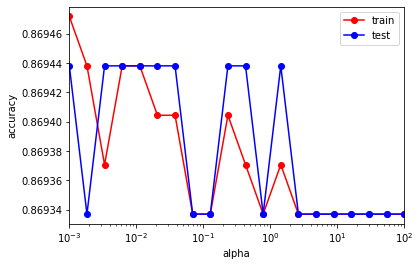

In [9]:
plt.semilogx(alpha_arr, train_acc, "r-o", label="train")
plt.semilogx(alpha_arr, test_acc, "b-o", label="test")
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.legend()
pass

Судя по графику, не наблюдается ни недообучения, ни переобучения. Колебания точности как на тренировочной, так и на тестовой выборке происходят в относительно малом диапазоне и, в целом, синхронно.

In [10]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.13052836915212054 0.13056200181616387


Получено оптимальное значение $\alpha$:

In [11]:
alpha_opt = alpha_arr[test_err == min_test_err][0]
print(alpha_opt)

0.001


Запустим классификацию при вычисленном оптимальном значении $\alpha$:

In [12]:
model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(100,),
                      solver="lbfgs", activation="logistic", max_iter=5000, random_state=5924)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Train: {}, Test: {}".format(
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_test, y_test_pred)
))

Train: 0.8694716308478795, Test: 0.8694379981838362


Можно также попробовать подобрать число нейронов в скрытом слое:

In [13]:
%%time

hlsize_arr = np.linspace(10, 200, 10).astype(int)
test_err = []
train_err = []
train_acc = []
test_acc = []

for hlsize in hlsize_arr:
    model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(hlsize,),
                          solver="lbfgs", activation="logistic", max_iter=5000, random_state=5924)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Wall time: 1min 28s


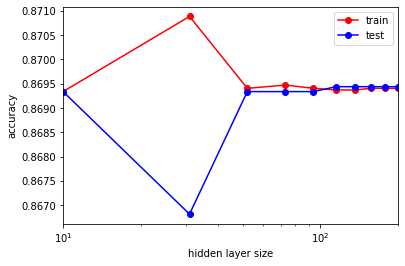

In [14]:
plt.semilogx(hlsize_arr, train_acc, "r-o", label="train")
plt.semilogx(hlsize_arr, test_acc, "b-o", label="test")
plt.xlim([np.min(hlsize_arr), np.max(hlsize_arr)])
plt.xlabel("hidden layer size")
plt.ylabel("accuracy")
plt.legend()
pass

При определенном числе нейронов есть падение точности на тестовой выборке и рост на тренировочной, то есть, переобучение, которое, впрочем, не наблюдается при других значениях параметра. В остальном, колебания точности происходят в относительно малом диапазоне как на тренировочной, так и на тестовой выборке, и нет ни недообучения, ни переобучения.

In [15]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.12911579726230116 0.13056200181616387


Получено оптимальное число нейронов:

In [16]:
hlsize_opt = hlsize_arr[test_err == min_test_err][0]
print(hlsize_opt)

115


Запустим классификацию при вычисленном оптимальном числе нейронов в скрытом слое:

In [17]:
model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(hlsize_opt,),
                      solver="lbfgs", activation="logistic", max_iter=5000, random_state=5924)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Train: {}, Test: {}".format(
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_test, y_test_pred)
))

Train: 0.8693707328557495, Test: 0.8694379981838362


Теперь попробуем заново подобрать одновременно и коэффициент регуляризации $\alpha$, и размер скрытого слоя:

In [18]:
%%time

alpha_arr = np.logspace(-3, 2, 10)
hlsize_arr = np.linspace(10, 200, 5).astype(int)
params = []
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    for hlsize in hlsize_arr:
        model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(hlsize,),
                                solver="lbfgs", activation="logistic", max_iter=5000, random_state=5924)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_err.append(np.mean(y_train != y_train_pred))
        test_err.append(np.mean(y_test != y_test_pred))
        train_acc.append(accuracy_score(y_train, y_train_pred))
        test_acc.append(accuracy_score(y_test, y_test_pred))
        params.append([alpha, hlsize])

Wall time: 2min 55s


Получены следующие оптимальные значения:

In [19]:
min_test_err = np.min(test_err)
i = np.where(test_err == min_test_err)[0][0]
alpha_opt, hlsize_opt = params[i]
print(alpha_opt, hlsize_opt)

0.003593813663804626 10


## Классификация

Теперь можно выполнить классификацию при оптимальных значениях гиперпараметров:

In [20]:
model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(hlsize_opt,),
                      solver="lbfgs", activation="logistic", max_iter=5000, random_state=5924)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Train: {}, Test: {}".format(
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_test, y_test_pred)
))


Train: 0.8694379981838362, Test: 0.869740692160226


### Матрица рассогласования

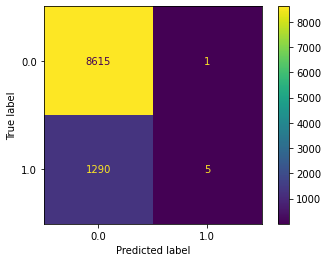

In [21]:
confusion = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=model.classes_)
display.plot()
plt.show()
pass

**Выводы:**

* При подборе оптимальных значений гиперпараметров не получилось достичь большого изменения точности, улучшение на тестовой выборке вышло не более порядка $10^{-4}$
* Исходя из этого, можно сказать, что у выбранного датасета не наблюдается явной зависимости точности от оптимизируемых гиперпараметров (значение alpha и число нейронов в скрытом слое)
* Ни недообучения, ни переобучения не наблюдалось ни на одном из этапов подбора оптимальных параметров